## Identify peaks per cluster

In [89]:
import numpy as np
import os
import sys
import logging
import collections
import matplotlib.pyplot as plt
import gzip
import glob
import loompy
import scipy.sparse as sparsourse
import urllib.request
import pybedtools
from pybedtools import BedTool
import MACS2

import sklearn.metrics
from scipy.spatial import distance
import community
import networkx as nx
from scipy import sparse
from typing import *

sys.path.append('/home/camiel/chromograph/')
from chromograph.peak_calling.utils import *
import chromograph


## Parameters
indir = '/data/proj/scATAC/chromograph/mouse_test2/'
f = os.path.join(indir, '10X_test_10kb.loom')
pf = os.path.join(indir, 'peaks')
macs_path = '/home/camiel/anaconda3/envs/chromograph/bin/macs2'
ref = '/data/ref/cellranger-atac/refdata-cellranger-atac-GRCh38-1.1.0'
gf = None
    
logger = logging.getLogger()
logger.setLevel(logging.INFO)

if not os.path.isdir(pf):
    os.mkdir(pf)

In [54]:
ds = loompy.connect(f)
print(ds.shape)

if ds.attrs['reference_organism'] == 'Homo_sapiens':
    g = 'hs'
elif ds.attrs['reference_organism'] == 'Mus_musculus':
    g = 'mm'

(271145, 4273)


In [105]:
ds.close()

7 7


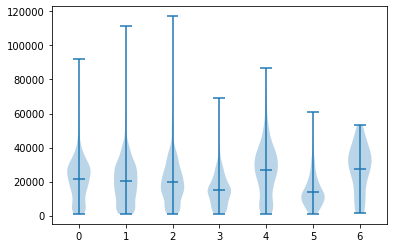

In [5]:
data = [ds.ca['passed_filters'][ds.ca['Clusters'] == x] for x in np.unique(ds.ca['Clusters'])]
# data = [np.log10(ds.ca['passed_filters'][ds.ca['Clusters'] == x]) for x in np.unique(ds.ca['Clusters'])]
print(len(data), len(np.unique(ds.ca['Clusters'])))
plt.violinplot(data, positions=np.unique(ds.ca['Clusters']), showmeans=True);

In [6]:
# for clus in np.unique(ds.ca['Clusters']):
#     cas = ds.ca['fragments'][ds.ca['Clusters'] == clus]
#     frags = [strFrags_to_list(x) for x in cas]
#     frags = [x for l in frags for x in l]
#     logging.info("Total fragments in cluster {}:  {}".format(clus, len(frags)))

#     fbed = os.path.join(pf, "fragments_cluster_{}.bed.gz".format(clus))
#     fpeaks = os.path.join(pf, "cluster_{}".format(clus))

#     print(g, fpeaks)
#     bed = BedTool(frags)
#     bed.saveas(fbed)

#     ## Call Peaks
#     cmd = "{} callpeak -t {} -f BEDPE -g {} --nomodel --shift 100 --ext 200 --qval 5e-2 -B --SPMR -n {}".format(macs_path, fbed, g, fpeaks)
#     os.system(cmd)

#     logging.info('Called peaks for cluster {} out of {}'.format(clus, np.unique(ds.ca['Clusters'])))
    
#     ## We only need the narrowPeak file, so clean up the rest
#     os.system("rm {}".format(os.path.join(pf, 'cluster_' + str(clus) + '_peaks.xls'))
#     os.system("rm {}".format(os.path.join(pf, 'cluster_' + str(clus) + '_control_lambda.bdg'))
#     os.system("rm {}".format(os.path.join(pf, 'cluster_' + str(clus) + '_summits.bed'))

13374967


## Generate compound peak list and count peaks

In [40]:
## Get all the narrowPeak files

peaks = [BedTool(x) for x in glob.glob(os.path.join(pf, '*.narrowPeak'))]
logging.info('Identified on average {} peaks per cluster'.format(np.int(np.mean([len(x) for x in peaks]))))
peaks_all = peaks[0].cat(*peaks[1:])
logging.info('Identified {} peaks after compounding list'.format(len(peaks_all)))

INFO:root:Identified on average 61746 peaks per cluster


In [62]:
ds.attrs['reference_assembly']

'mm10'

In [104]:
#### Import the elements you want to use to annotate the peaks
ref = '/data/ref/cellranger-atac/refdata-cellranger-atac-GRCh38-1.1.0'

elements = ['dnase', 'enhancer', 'promoter', 'tss', 'transcripts']

for x in elements:
    el = BedTool(os.path.join(ref, 'regions', x + '.bed'))
    print(el.head())

chr1	10137	10352	chr1:10137-10352	857	.
 chr1	10448	10574	chr1:10448-10574	781	.
 chr1	16201	16288	chr1:16201-16288	771	.
 chr1	17467	17526	chr1:17467-17526	838	.
 chr1	96535	96647	chr1:96535-96647	986	.
 chr1	96570	96670	chr2:243181094-243181194	994	.
 chr1	99581	99757	chr1:99581-99757	991	.
 chr1	104950	105019	chr1:104950-105019	995	.
 chr1	115661	115809	chr1:115661-115809	993	.
 chr1	136365	136492	chr1:136365-136492	966	.
 None
chr1	19714	23399	.	.	.
 chr1	49800	70600	.	.	.
 chr1	71800	73000	.	.	.
 chr1	73200	73800	.	.	.
 chr1	78200	79400	.	.	.
 chr1	81000	83400	.	.	.
 chr1	83600	91599	.	.	.
 chr1	92000	92200	.	.	.
 chr1	101600	101800	.	.	.
 chr1	103601	105399	.	.	.
 None
chr1	27599	31401	.	.	.
 chr1	36199	37001	.	.	.
 chr1	267999	268201	.	.	.
 chr1	272999	274401	.	.	.
 chr1	586199	586601	.	.	.
 chr1	587799	588001	.	.	.
 chr1	628999	630001	.	.	.
 chr1	630799	635200	.	.	.
 chr1	777399	780401	.	.	.
 chr1	816399	818201	.	.	.
 None
chr1	11868	11869	DDX11L1	.	+	transcribed_unprocessed_ps

In [97]:
# for x in Gencode[0]:
#     print(x)
# for x in ensemble[0]:
#     print(x)
Gencode.head()

##gff-version 3
 #description: evidence-based annotation of the mouse genome (GRCm38), version M23 (Ensembl 98)
 #provider: GENCODE
 #contact: gencode-help@ebi.ac.uk
 #format: gff3
 #date: 2019-09-06
 ##sequence-region chr1 1 195471971
 chr1	HAVANA	gene	3073253	3074322	.	+	.	ID=ENSMUSG00000102693.1;gene_id=ENSMUSG00000102693.1;gene_type=TEC;gene_name=4933401J01Rik;level=2;mgi_id=MGI:1918292;havana_gene=OTTMUSG00000049935.1
 chr1	HAVANA	transcript	3073253	3074322	.	+	.	ID=ENSMUST00000193812.1;Parent=ENSMUSG00000102693.1;gene_id=ENSMUSG00000102693.1;transcript_id=ENSMUST00000193812.1;gene_type=TEC;gene_name=4933401J01Rik;transcript_type=TEC;transcript_name=4933401J01Rik-201;level=2;transcript_support_level=NA;mgi_id=MGI:1918292;tag=basic;havana_gene=OTTMUSG00000049935.1;havana_transcript=OTTMUST00000127109.1
 chr1	HAVANA	exon	3073253	3074322	.	+	.	ID=exon:ENSMUST00000193812.1:1;Parent=ENSMUST00000193812.1;gene_id=ENSMUSG00000102693.1;transcript_id=ENSMUST00000193812.1;gene_type=TEC;gene_

In [99]:
annot = Gencode.intersect(peaks_all, u=True)
print(len(peaks_all), '   ', len(annot))
annot[0] 

155345     344326


Interval(chr1:3205900-3671498)

gene,transcript,exon,CDS,UTR,start_codon,stop_codon,Selenocysteine

In [100]:
feature = []
for x in annot:
    feature.append(x[2])
    
print(np.unique(feature))

['CDS' 'exon' 'five_prime_UTR' 'gene' 'start_codon' 'stop_codon'
 'stop_codon_redefined_as_selenocysteine' 'three_prime_UTR' 'transcript']


## Find Differentially accessible regions for the identified clusters

In [26]:
## Get GENCODE annotion
gf = None

def download_GENCODE(ref: str):
    '''
    '''

    if ref == 'GRCh38':
        url = 'ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_32/gencode.v32.annotation.gtf.gz'
        logging.info("url: {}".format(url))
        ver = 'v32'
    elif ref == 'hg19':
        url = 'https://www.encodeproject.org/files/gencode.v19.annotation/@@download/gencode.v19.annotation.gtf.gz'        
        logging.info("url: {}".format(url))
        ver = 'v19'
    elif ref == 'mm10':
        url = 'https://www.encodeproject.org/files/gencode.vM4.annotation/@@download/gencode.vM4.annotation.gtf.gz'
        logging.info("url: {}".format(url))
        ver = 'vM4'
    else:
        logging.info("Genome not recognised")
        return
    
    tmp = urllib.request.urlopen(url)
    datatowrite = tmp.read()

    if not os.path.isdir('./tmp'):
        os.mkdir('tmp')

    file = 'tmp/GENCODE_{}.gtf.gz'.format(ver)
        
    with open(file, 'wb') as f:
        f.write(datatowrite)

    return file;

if gf == None:
    gf = download_GENCODE(ds.attrs['reference_assembly'])
    logging.info("downloaded: {}".format(gf))
    
GENCODE = BedTool(gf)
GENCODE[0]

INFO:root:url: https://www.encodeproject.org/files/gencode.vM4.annotation/@@download/gencode.vM4.annotation.gtf.gz
INFO:root:downloaded: tmp/GENCODE_vM4.gtf.gz


Interval(chr1:3073252-3074322)